# Data Exploration

## Visualisation

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('fivethirtyeight')
plt.rcParams['font.size'] = 14
plt.figure(figsize=(12,5))
palette = sns.color_palette('Paired', 10)

<Figure size 864x360 with 0 Axes>

### Distribution

In [8]:
def plot_dist(series, title = "Distribution"):
    ''' 
    Normalized counts so that the area of the histogram is 1.
    Bars are centered on their corresponding data points to avoid gaps.
    '''
    sns.histplot(series, kde = True, stat = "density", discrete = True)
    sns.despine()
    plt.title(title);
    plt.show()

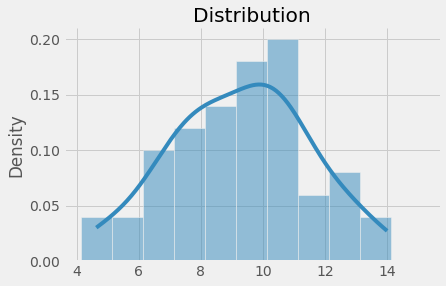

In [9]:
import numpy as np
plot_dist(np.random.normal(10,2, 50))

### Correlation:  `sns.catplot` 

Firstly, you can visualize the target variable vs another variable. 
- For categorical variables, it is often useful to compute the average target variable for each category.
```python
sns.catplot(kind = "bar")
```
- For continuous variables(like distance), you can use scatter plots, or regression plots, or bucket the distance into different bins.
```python
sns.scatterplot()
```

- bucket：

```python
# We can also visualise binned fare_amount variable
df['fare-bin'] = pd.cut(df['fare_amount'], bins = list(range(0, 50, 5))).astype(str)

# Uppermost bin
df.loc[df['fare-bin'] == 'nan', 'fare-bin'] = '[45+]'

# Adjust bin so the sorting is correct
df.loc[df['fare-bin'] == '(5, 10]', 'fare-bin'] = '(05, 10]'

sns.catplot(x="fare-bin", kind="count", palette=palette, data=df, height=5, aspect=3);
sns.despine()
plt.show()
```

## Time Features

In [15]:
import datetime, pytz
now = datetime.datetime.now()

In [18]:
def extract_time_features(df, time_column = "timestamp", timezone = "UTC"):
    '''
    Use this function to extract time features from timestamp
    '''   
    time_column = time_column
    timezone = timezone
    df.index = pd.to_datetime(df[time_column])
    df.index = df.index.tz_convert(timezone)
    df['dow'] = df.index.weekday
    df['hour'] = df.index.hour
    df['month'] = df.index.month
    df['year'] = df.index.year
    return df.reset_index(drop = True)

In [20]:
def plot_time_features(df, x = "dow"):
    palette = sns.color_palette('Paired', 10)
    sns.catplot(x = x, kind = "count", palette = palette, data = df,
               height = 5, aspect = 3)
    sns.despine()
    plt.title(f"{x.capitalize()} Count")
    plt.show()
    

## Geospatial Data

In [22]:
import folium
from folium.plugins import HeatMap
from folium.plugins import HeatMapWithTime

def generate_map(df, latitude_col, longitude_col):
    '''
    Generate a map centered at the mean of latitude/longitude.
    Input the column name (string) of coordinate series.
    '''
    center_location = [df[latitude_col].mean(), df[longitude_col].mean()]   
    m = folium.Map(location = center_location,
                   control_scale = True,
                   zoom_start = 11)
    return m
    
def plot_heatmap(df, latitude_col, longitude_col, n_sample = 1_000):

    m = generate_map(df, latitude_col, longitude_col)
    
    if 'count' not in df.columns:
        df['count'] = 1
           
    heatmap_data = df.sample(n_sample)[[latitude_col, longitude_col, "count"]]\
                    .groupby([latitude_col, longitude_col]).sum().reset_index().values.tolist()
    gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'}
    
    HeatMap(data = heatmap_data, radius = 5, gradient=gradient,
            max_zoom = 13).add_to(m)
    return m

def plot_heatmap_by_time(df, latitude_col, longitude_col, time_col, n_sample = 1_000):
    '''
    Categorical time like hour, day rather than continues time.
    '''
    m = generate_map(df, latitude_col, longitude_col)
    if 'count' not in df.columns:
        df['count'] = 1
    
    heatmap_data_by_time = []
    __df__ = df.sample(n_sample)
    for time in df[time_col].sort_values().unique():
        _df = __df__[__df__[time_col] == time][[latitude_col, longitude_col, 'count']]\
              .groupby([latitude_col, longitude_col]).sum().reset_index().values.tolist()
        heatmap_data_by_time.append(_df)
    HeatMapWithTime(heatmap_data_by_time,
                    radius = 5,
                    gradient = {0.2: 'blue', 0.4: 'lime', 0.6: 'orange', 1: 'red'},
                    min_opacity=0.5, max_opacity=0.8, 
                    use_local_extrema=False).add_to(m)
    return m

## Distance

### Manhattan & Euclidian Distance

In [ ]:
def minkowski_distance(x1, x2, y1, y2, p):
    delta_x = x1 - x2
    delta_y = y1 - y2
    return ((abs(delta_x) ** p) + (abs(delta_y)) ** p) ** (1 / p)

def deg2rad(coordinate):
    return coordinate * np.pi / 180
    
# convert radians into distance
def rad2dist(coordinate):
    earth_radius = 6371 # km
    return earth_radius * coordinate
    
# correct the longitude distance regarding the latitude (https://jonisalonen.com/2014/computing-distance-between-coordinates-can-be-simple-and-fast/)
def lng_dist_corrected(lng_dist, lat):
    return lng_dist * np.cos(lat)

def minkowski_distance_gps(lat1, lat2, lon1, lon2, p):
    lat1, lat2, lon1, lon2 = [deg2rad(coordinate) for coordinate in [lat1, lat2, lon1, lon2]]
    y1, y2, x1, x2 = [rad2dist(angle) for angle in [lat1, lat2, lon1, lon2]]
    x1, x2 = [lng_dist_corrected(elt['x'], elt['lat']) for elt in [{'x': x1, 'lat': lat1}, {'x': x2, 'lat': lat2}]]
    return minkowski_distance(x1, x2, y1, y2, p)

def get_manhattan_distance(lat1, lat2, lon1, lon2):
    return minkowski_distance_gps(lat1, lat2, lon1, lon2, 1)

def get_euclidian_distance(lat1, lat2, lon1, lon2):
    return minkowski_distance_gps(lat1, lat2, lon1, lon2, 2)


### Haversine_distance

In [27]:
import numpy as np

def get_haversine_distance(lat1, lat2, lon1, lon2):
    """
        Calculate the great circle distance between two points 
        on the earth (specified in decimal degrees).
        Return a pandas Series.
    """

    lat_1_rad, lon_1_rad = np.radians(lat1.astype(float)), np.radians(lon1.astype(float))
    lat_2_rad, lon_2_rad = np.radians(lat2.astype(float)), np.radians(lon2.astype(float))
    dlon = lon_2_rad - lon_1_rad
    dlat = lat_2_rad - lat_1_rad

    a = np.sin(dlat / 2.0) ** 2 + np.cos(lat_1_rad) * np.cos(lat_2_rad) * np.sin(dlon / 2.0) ** 2
    c = 2 * np.arcsin(np.sqrt(a))
    haversine_distance = 6371 * c
    return haversine_distance


# Scorer

In [102]:
## Custom Scorer

# Pipeline

## Custom Transformers

### Distance Transformer

In [29]:
from sklearn.base import BaseEstimator, TransformerMixin

class DistanceTransformer(BaseEstimator, TransformerMixin):
    '''
        Compute the haversine distance between two GPS points.
        Return a copy of the DataFrame X with only one column: 'distance'
    '''
    def __init__(self, 
                 lat1 = "start_latitude", 
                 lat2 = "end_latitude", 
                 lon1 = "start_longitude", 
                 lon2 = "end_longitude"):
        self.lat1 = lat1
        self.lat2 = lat2
        self.lon1 = lon1
        self.lon2 = lon2
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y = None):
        assert isinstance(X, pd.DataFrame)
        X_ = X.copy()
        X_["distance"] = get_haversine_distance(X_[self.lat1],
                                                X_[self.lat2],
                                                X_[self.lon1],
                                                X_[self.lon2])
        return X_[['distance']]

### TimeFeatureEncoder

In [35]:
class TimeFeaturesEncoder(BaseEstimator, TransformerMixin):
    """
        Extract the day of week (dow), the hour, the month and the year from a timestamp column.
        Return a copy of the DataFrame X with only four columns: 'dow', 'hour', 'mont', 'year'.
    """
    def __init__(self, time_col = "time_stamp", time_zone = "UTC"):
        self.time_col = time_col
        self.time_zone = time_zone
        
    def fit(self, X, y = None):
        return self
    
    def transform(self, X, y=None):
        assert isinstance(X, pd.DataFrame)
        X_ = X.copy()
        X_.index = pd.to_datetime(X[self.time_col])
        X_.index = X_.index.tz_convert(self.time_zone)
        X_['dow'] = X_.index.weekday
        X_['hour'] = X_.index.hour
        X_["month"] = X_.index.month
        X_["year"] = X_.index.year
        return X_[['dow', 'hour', 'month', 'year']]   

## set pipeline

### Preprocessing

In [36]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# create distance pipeline
dist_pipe = Pipeline([
    ('dist_trans', DistanceTransformer()),
    ('stdscaler', StandardScaler())
])


# create time pipeline
time_pipe = Pipeline([
    ('time_enc', TimeFeaturesEncoder()),
    ('ohe', OneHotEncoder(handle_unknown='ignore'))
])

# create preprocessing pipeline
preproc_pipe = ColumnTransformer([
    ('distance', dist_pipe, ["pickup_latitude", "pickup_longitude", 'dropoff_latitude', 'dropoff_longitude']),
    ('time', time_pipe, ['pickup_datetime'])
], remainder="drop")

### Model Pipeline

In [37]:
from sklearn.linear_model import LinearRegression

# Add the model of your choice to the pipeline
pipe = Pipeline([
  ('preproc', preproc_pipe),
  ('linear_model', LinearRegression())
])

# display the pipeline with model
pipe

Pipeline(steps=[('preproc',
                 ColumnTransformer(transformers=[('distance',
                                                  Pipeline(steps=[('dist_trans',
                                                                   DistanceTransformer()),
                                                                  ('stdscaler',
                                                                   StandardScaler())]),
                                                  ['pickup_latitude',
                                                   'pickup_longitude',
                                                   'dropoff_latitude',
                                                   'dropoff_longitude']),
                                                 ('time',
                                                  Pipeline(steps=[('time_enc',
                                                                   TimeFeaturesEncoder()),
                                                        

### Put Together

In [ ]:
def set_pipeline():
    '''returns a pipelined model'''
    dist_pipe = Pipeline([
        ('dist_trans', DistanceTransformer()),
        ('stdscaler', StandardScaler())
    ])
    time_pipe = Pipeline([
        ('time_enc', TimeFeaturesEncoder('pickup_datetime')),
        ('ohe', OneHotEncoder(handle_unknown='ignore'))
    ])
    preproc_pipe = ColumnTransformer([
        ('distance', dist_pipe, ["pickup_latitude", "pickup_longitude", 'dropoff_latitude', 'dropoff_longitude']),
        ('time', time_pipe, ['pickup_datetime'])
    ], remainder="drop")
    pipe = Pipeline([
        ('preproc', preproc_pipe),
        ('linear_model', LinearRegression())
    ])
    return pipe

In [ ]:
#implement train() function
def train(X_train, y_train, pipeline):
    '''returns a trained pipelined model'''
    pipeline.fit(X_train, y_train)
    return pipeline

In [ ]:
#implement evaluate() function
def evaluate(X_test, y_test, pipeline, metric):
    '''returns the value of the RMSE'''
    y_pred = pipeline.predict(X_test)
    score = metric(y_pred, y_test)
    print(score)
    return score

### typical pipeline

In [1]:
# visualizing pipelines in HTML
from sklearn import set_config; set_config(display='diagram')

In [74]:
from sklearn import datasets
import pandas as pd

data = pd.read_csv("data.csv")
data.dropna(inplace = True)

y = data.pop('charges')
X = data

In [30]:
from sklearn.base import TransformerMixin, BaseEstimator

class CustomScaler(TransformerMixin, BaseEstimator): 
# TransformerMixin generates a fit_transform method from fit and transform
# BaseEstimator generates get_params and set_params methods
    
    def __init__(self, shrink_factor):
        self.shrink_factor = shrink_factor
    
    def fit(self, X, y=None):
        self.means = X.mean()
        return self
    
    def transform(self, X, y=None):
        X_transformed = (X - self.means) / self.shrink_factor
        # Return result as dataframe for integration into ColumnTransformer
        return pd.DataFrame(X_transformed)

In [44]:
class CustomOHE2(TransformerMixin, BaseEstimator):
    def __init__(self):
        pass
    
    def fit(self, X):
        X_dummified = pd.get_dummies(X)
        self.columns = X_dummified.columns
        return self
    
    def transform(self, X):
        X_dummified = pd.get_dummies(X)
        # Only keep columns that are computed in the fit() method
        # Drop new dummy columns if new category appears in the test set that were never seen in train set
        X_dummified_reindexed = X_dummified.reindex(columns=self.columns, fill_value=0)
        return X_dummified_reindexed
    
class CustomColumnTransformer(ColumnTransformer):
    def transform(self, *args, **kwargs):
        return pd.DataFrame(super().transform(*args, **kwargs), columns=self.get_feature_names())
    def fit_transform(self, *args, **kwargs):
        return pd.DataFrame(super().fit_transform(*args, **kwargs), columns=self.get_feature_names())

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.linear_model import Ridge

from tempfile import mkdtemp
from shutil import rmtree

# Create a temp folder
cachedir = mkdtemp()

num_transformer = MinMaxScaler()
cat_transformer = OneHotEncoder(handle_unknown = 'ignore')

preprocessor = ColumnTransformer([
    ("num_transformer", num_transformer, make_column_selector(dtype_include = ['int', 'float'])),
    ("cat_transformer", cat_transformer, make_column_selector(dtype_include = ['object', 'bool']))
])
pipe = Pipeline([
    ('preprocessing', preprocessor),
    ('linear_regression', Ridge())
], 
    memory = cachedir # Avoid recalculating transformer variables during cross validations or grid searches
)

# Clear the cache directory after the cross-validation
rmtree(cachedir)
pipe

Pipeline(memory='/var/folders/dt/552dh9wd7yx6f5wxdyrg4ghw0000gn/T/tmpn90zwhp3',
         steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125c3ce50>),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125c44520>)])),
                ('linear_regression', Ridge())])

In [91]:
pipe.fit(X,y)

Pipeline(memory='/var/folders/dt/552dh9wd7yx6f5wxdyrg4ghw0000gn/T/tmpn90zwhp3',
         steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_transformer',
                                                  MinMaxScaler(),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125c3d370>),
                                                 ('cat_transformer',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x125c3d220>)])),
                ('linear_regression', Ridge())])

## GridSearch

In [92]:
from sklearn.model_selection import cross_val_score

# Cross validate pipeline
cross_val_score(pipe, X, y, cv=5, scoring='r2').mean()

0.7463757475045647

In [93]:
#### Get all pipe components parameters (to find hyper params names)
for param in pipe.get_params().keys():
    print(param, ":", pipe.get_params()[param])

memory : /var/folders/dt/552dh9wd7yx6f5wxdyrg4ghw0000gn/T/tmpn90zwhp3
steps : [('preprocessing', ColumnTransformer(transformers=[('num_transformer', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x125c3d370>),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x125c3d220>)])), ('linear_regression', Ridge())]
verbose : False
preprocessing : ColumnTransformer(transformers=[('num_transformer', MinMaxScaler(),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x125c3d370>),
                                ('cat_transformer',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0

In [89]:
from sklearn.model_selection import GridSearchCV

# Instanciate grid search
grid_search = GridSearchCV(
    pipe, 
    param_grid={
        # Access any component of the pipeline, as far back as you want
        'linear_regression__alpha': [0.1, 0.5, 1, 5, 10]},
    cv=5,
    scoring="r2")

grid_search.fit(X, y)
grid_search.best_params_

{'linear_regression__alpha': 0.5}

In [95]:
tuned_pipe = grid_search.best_estimator_

### Save pipe

In [96]:
import pickle

# Export pipeline as pickle file
with open("pipeline.pkl", "wb") as file:
    pickle.dump(tuned_pipe, file)

# Load pipeline from pickle file
my_pipeline = pickle.load(open("pipeline.pkl","rb"))

# my_pipeline.predict(X_test, y_test)

## TPOT: Tree-based Pipeline Optimization Tool

In [101]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

from tpot import TPOTClassifier

# load iris dataset
iris = load_iris()
# hold out
X_train, X_test, y_train, y_test = train_test_split(iris.data.astype(np.float64),
    iris.target.astype(np.float64), train_size=0.75, test_size=0.25)
# instanciate TPOTClassifier
tpot = TPOTClassifier(generations=5, population_size=50, verbosity=2)
# process autoML with TPOT
tpot.fit(X_train, y_train)
# print score
print(tpot.score(X_test, y_test))
# export TPOT pipeline to a python file
tpot.export('tpot_iris_pipeline.py')



Generation 1 - Current best internal CV score: 0.9826086956521738

Generation 2 - Current best internal CV score: 0.9826086956521738

Generation 3 - Current best internal CV score: 0.9826086956521738

Generation 4 - Current best internal CV score: 0.9826086956521738

Generation 5 - Current best internal CV score: 0.9826086956521738

Best pipeline: LogisticRegression(SGDClassifier(input_matrix, alpha=0.001, eta0=0.01, fit_intercept=True, l1_ratio=1.0, learning_rate=constant, loss=perceptron, penalty=elasticnet, power_t=10.0), C=5.0, dual=False, penalty=l2)
0.9473684210526315


# MlFlow QuickStart

In [45]:
from mlflow.tracking import MlflowClient

EXPERIMENT_NAME = "test-mlflow-class"

client = MlflowClient()
try:
    experiment_id = client.get_experiment_by_name(EXPERIMENT_NAME).experiment_id
except:
    experiment_id = client.create_experiment(EXPERIMENT_NAME)

run = client.create_run(experiment_id)
client.log_metric(run.info.run_id, "rmse", 4.5)
client.log_param(run.info.run_id, "model", "Randomforest")

In [ ]:
! mlflow ui

[2021-01-28 23:10:20 +0100] [66491] [INFO] Starting gunicorn 20.0.4
[2021-01-28 23:10:20 +0100] [66491] [INFO] Listening at: http://127.0.0.1:5000 (66491)
[2021-01-28 23:10:20 +0100] [66491] [INFO] Using worker: sync
[2021-01-28 23:10:20 +0100] [66493] [INFO] Booting worker with pid: 66493


In [52]:
from memoized_property import memoized_property
import mlflow
from mlflow.tracking import MlflowClient

class Mlflow(object):
    
    def __init__(self, experiment_name):
        self.experiment_name = experiment_name
    
    @memoized_property
    def mlflow_client(self):
        return MlflowClient()
    
    @memoized_property
    def mlflow_experiment_id(self):
        try:
            return self.mlflow_client.\
                    create_experiment(self.experiment_name)
        except BaseException:
            return self.mlflow_client.\
                    get_experiment_by_name(self.experiment_name).experiment_id
        
    def mlflow_create_run(self):
        self.mlflow_run = self.mlflow_client.create_run(self.mlflow_experiment_id)
        
    def mlflow_log_param(self, key, value):
        self.mlflow_client.log_param(self.mlflow_run.info.run_id, key, value)
        
    def mlflow_log_metric(self, key, value):
        self.mlflow_client.log_metric(self.mlflow_run.info.run_id, key, value)
        
    def train(self):      
        self.mlflow_create_run()
        self.mlflow_log_param("model", "linear")
        self.mlflow_log_metric("rmse", 4)
        
trainer = Mlflow("test-mlflow-class")
trainer.train()
    